In [1]:
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
class SmallVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
       
        model = Sequential()   
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":   
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL layer set              
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))                 
        model.add(BatchNormalization(axis=chanDim))   
        model.add(MaxPooling2D(pool_size=(2, 2)))     
        model.add(Dropout(0.25))                      
        # (CONV => RELU) * 2 => POOL layer set          
        model.add(Conv2D(64, (3, 3), padding="same"))   
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 3 => POOL layer set
        model.add(Conv2D(128, (3, 3), padding="same"))   
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of fully connected layer (FC) => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import pickle
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

In [8]:
print("[INFO] loading images...")
images = []
labels = []


imagePaths = sorted(list(paths.list_images('gender_dataset_face')))
random.seed(42)
random.shuffle(imagePaths)


for imagePath in imagePaths:
    
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))   
    images.append(image)

    
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)


images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)

print('done')

[INFO] loading images...
done


In [9]:
(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.2, random_state=42)

# before transformation
trainY

array(['woman', 'woman', 'man', ..., 'man', 'man', 'man'], dtype='<U5')

In [10]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# after transformation
trainY

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [11]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


model = SmallVGGNet.build(width=64, height=64, depth=3, classes=len(lb.classes_))


INIT_LR = 0.01
EPOCHS = 50
BS = 42

print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


H = model.fit_generator( aug.flow(trainX, trainY, batch_size=BS),
                        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS,
                        callbacks=[keras.callbacks.EarlyStopping(patience=11, verbose=1, restore_best_weights=True),
                                   keras.callbacks.ReduceLROnPlateau(factor=.5, patience=4, verbose=1)] )

model.save('gender_detection1.model')

[INFO] training network...
Epoch 1/50
43/43 [==============================] - 173s 4s/step - loss: 0.9932 - accuracy: 0.6023 - val_loss: 0.6866 - val_accuracy: 0.5043
Epoch 2/50
43/43 [==============================] - 162s 4s/step - loss: 0.7069 - accuracy: 0.6938 - val_loss: 0.8426 - val_accuracy: 0.4978
Epoch 3/50
43/43 [==============================] - 165s 4s/step - loss: 0.6005 - accuracy: 0.7399 - val_loss: 0.7603 - val_accuracy: 0.4978
Epoch 4/50
43/43 [==============================] - 164s 4s/step - loss: 0.4744 - accuracy: 0.7913 - val_loss: 0.9092 - val_accuracy: 0.4978
Epoch 5/50
43/43 [==============================] - 160s 4s/step - loss: 0.4399 - accuracy: 0.8167 - val_loss: 0.9551 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/50
43/43 [==============================] - 111s 3s/step - loss: 0.4141 - accuracy: 0.8134 - val_loss: 1.1039 - val_accuracy: 0.4978
Epoch 7/50
43/43 [=============================

In [15]:
print("Classification Report CNN")
predictions = model.predict(testX, batch_size=42)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

Classification Report CNN
              precision    recall  f1-score   support

         man       1.00      0.56      0.71       462
       woman       0.00      0.00      0.00         0

    accuracy                           0.56       462
   macro avg       0.50      0.28      0.36       462
weighted avg       1.00      0.56      0.71       462



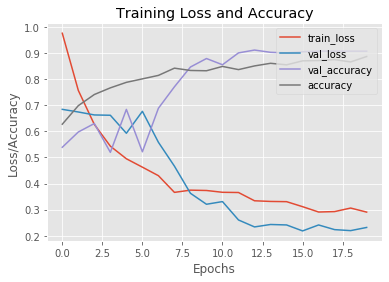

In [19]:
plt.style.use("ggplot")
plt.figure()
N = np.arange(0, EPOCHS)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
plt.plot(N, H.history["accuracy"], label="accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

plt.savefig('plot.png')

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import cvlib as cv

In [20]:
model = load_model('gender_detection1.model')

webcam = cv2.VideoCapture(0)
    

In [ ]:
classes = ['man','woman']

while webcam.isOpened():
 
    status, frame = webcam.read()
    
    face1,confidence1= cv.detect_face(frame)


    for idx, f in enumerate(face1):
  
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        face_crop = cv2.resize(face_crop, (96,96))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        conf = model.predict(face_crop)[0] 

        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)
        
    cv2.imshow("gender detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
webcam.release()
cv2.destroyAllWindows()